In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn import preprocessing
import seaborn as sns

# Spis Treści
1. [Metoda K-średnich](#kmeans)
    1. [Powtórka](#kmeans)
    2. [Mini Batch K-means](#mbkmeans)
    3. [Zadanie](#kmeans_task)
2. [DBSCAN](#DBSCAN)
    1. [Teoria](#DBSCAN)
    2. [Przykład](#DBSCAN_example)
    3. [Zadanie](#DBSCAN_task)
    4. [Źródła](#DBSCAN_sources)
3. [GMM](#GMM)
    1. [Teoria](#GMM)
    2. [Przykład](#GMM_example)
    3. [Zadanie](#GMM_task)
    4. [Źródła](#GMM_sources)
4. [Standaryzacja](#standardization)

Przygotowanie danych:

In [2]:
# Przygotowanie danych
n_samples = 1500
noisy_circles, y = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons, y = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs, y = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

X, y = datasets.make_blobs(n_samples=n_samples, random_state=1)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso_noisy = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
X_batch_blobs, y_batch_blobs= datasets.make_blobs(n_samples=np.linspace(1000, 21000, 11, dtype=np.int), 
                                                  random_state=8, 
                                                  center_box=(-100, 100), 
                                                  cluster_std=np.linspace(1, 5, 11))

## Metoda K-średnich <a name="kmeans"></a>




Przypomnienie:  
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
<div align="center">Żródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68</div>

<details>
<summary>Zalety?</summary>
    
   - niska złożoność, a co za tym idzie wysoka wydajność działania,
    
   - działa szybko przy dużych zbiorach i niskich ilościach grup,
    
   - pogrupowane zbiory są z reguły bardziej ciaśniejsze i zbite.
</details>

<details>
<summary>Wady?</summary>
    
   - nie pomaga w określeniu ilości grup (K),
    
   - różne wartości początkowe prowadzą do różnych wyników,
    
   - działa dobrze tylko dla „sferycznych” skupisk o jednorodnej gęstości.
</details>

<details>
<summary>Pytania - co możemy poprawić?</summary>
    
   - Co zrobić jeśli mamy bardzo dużo danych?
   
   - Co jeśli dane nie są sferyczne?
   
   - Może automatyczna detekcja liczby skupień?
</details>

### Metoda Mini Batch <a name="mbkmeans"></a>
- Algorytm pobiera małe losowo wybrane *mini batche* danych dla każdej iteracji. 
- W każdej iteracji dane z *mini batcha* są przypisane do klastrów, w zależności od poprzednich lokalizacji centroidów
- Następnie aktualizuje lokalizacje centroidów na podstawie nowych punktów z *mini batcha*. 

In [3]:
len(X_batch_blobs[:,0])

121000

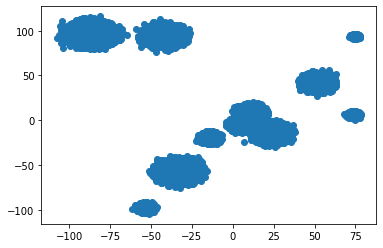

In [4]:
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

In [5]:
def _KMeans(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    return X, kmeans

def _MiniBatchKMeans(X, n_clusters):
    miniBatchKmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
    miniBatchKmeans.fit(X)
    return X, miniBatchKmeans

Porównanie czasów działania:

In [6]:
%%time
kmeans=_KMeans(X_batch_blobs, n_clusters=11)

CPU times: user 4.32 s, sys: 152 ms, total: 4.48 s
Wall time: 949 ms


In [7]:
%%time
batch_kmeans=_MiniBatchKMeans(X_batch_blobs, n_clusters=11)

CPU times: user 568 ms, sys: 173 µs, total: 569 ms
Wall time: 568 ms


In [8]:
def plot_clusters(X, model, title="", **kwargs):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np.int)
    else:
        y_pred = model.predict(X)
    plt.scatter(X[:,0],X[:,1],c=y_pred, cmap='viridis', **kwargs)
    plt.title(title)
    plt.show()

Wizualizacja podziału:

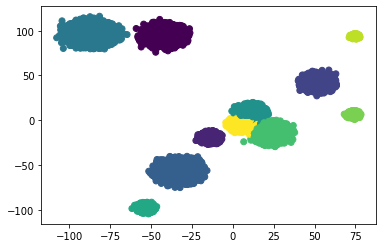

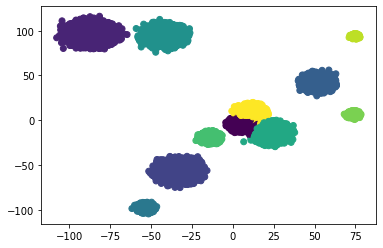

In [9]:
plot_clusters(*kmeans)
plot_clusters(*batch_kmeans)

### Zadanie * <a name="kmeans_task"></a>

## DBSCAN  <a name="DBSCAN"></a>
### Density-based spatial clustering of applications with noise 

DBSCAN prezentuje inne podejście do problemów analizy skupień, oparte na analizie gęstości.

Dwa podstawowe parametry:
 - $\epsilon$,
 - **minPts**

Sposób działania:

   1. Znajdź punkty w sąsiedztwie ($\epsilon$) każdego punktu, znajdź "punkty bazowe" (ang. core points) mające więcej niż **minPts** sąsiadów.
   2. Znajdź spójne składowe punktów bazowych, pomijając wszystkie pozostałe punkty,
   3. Przypisz każdy pozostały punkt do najbliższego klastra, jeśli jest w jego sąsiedztwie, w przeciwnym wypadku oznacz go jako szum/obserwację odstającą.
  


<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" alt="drawing" width="400"/>

In this diagram, minPts = 4. Point A and the other red points are core points, because the area surrounding these points in an ε radius contain at least 4 points (including the point itself). Because they are all reachable from one another, they form a single cluster. Points B and C are not core points, but are reachable from A (via other core points) and thus belong to the cluster as well. Point N is a noise point that is neither a core point nor directly-reachable.

Źródło ilustracji: https://en.wikipedia.org/wiki/DBSCAN

![Alt Text](https://dashee87.github.io/images/DBSCAN_tutorial.gif)

Źródło: https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/

### Przykład <a name="DBSCAN_example"></a>

In [10]:
def _DBSCAN(X, eps=0.3, **kwargs):
    dbs = cluster.DBSCAN(eps=eps, **kwargs)
    dbs.fit(X)
    return X, dbs

Podstawowe parametry *sklearn.cluster.DBSCAN*: 

`eps` default=0.5  
`min_samples` default=5   
`metric` default = 'euclidean'  

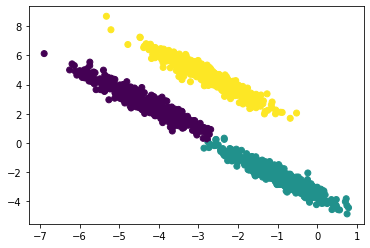

In [11]:
plot_clusters(*_KMeans(X_aniso, n_clusters=3))

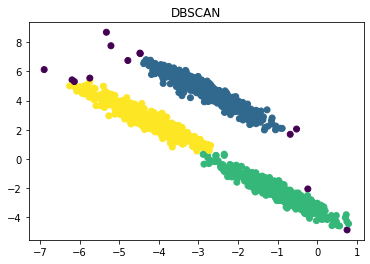

In [12]:
plot_clusters(*_DBSCAN(X_aniso), title="DBSCAN")

### Zadanie <a name="DBSCAN_task"></a>  

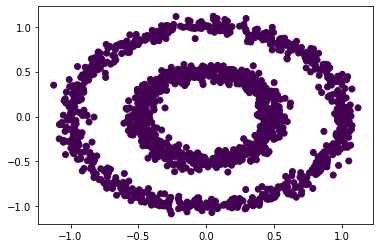

In [33]:
plot_clusters(*_DBSCAN(noisy_circles, eps=0.5,min_samples=5))

### Więcej <a name="DBSCAN_sources"></a>  

 - https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/DBScan_Clustering.ipynb

 - Przykład z dokumentacji: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
 
 - DBSCAN Revisited, Revisited: Why and How You Should (Still) Use DBSCAN (2017): https://dl.acm.org/doi/10.1145/3068335

## GMM (Gaussian Mixture Models) <a name="GMM"></a>

Jeszcze inne podejście oparte na modelowaniu skupień przy pomocy rozkładów normalnych.

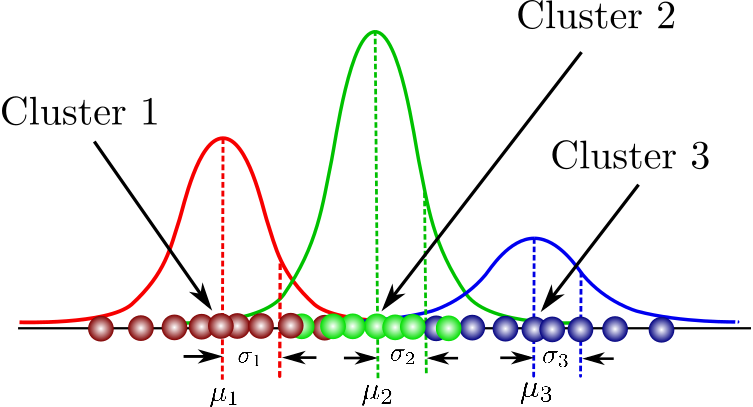

Źródło:https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

Dla **K** klastrów mamy **K** funkcji o 3 podstawowych parametrach:
 - $\mu$ - średnia określająca centrum,
 - $\Sigma$ - macierz kowariancji, określająca szerokość. W wielu wymiarach określa wymiary elipsoidy. 
 - $\pi$ - określa wysokość, $\sum_{k}^{K}  \pi_{k} = 1$

Joint probability distribution:

$P(x) = \sum_{c=1}^K \pi_c N(\mu_c, \Sigma_c)$

Do wyestymowania parametrów $\mu$, $\Sigma$ i $\pi$ wykorzystujemy [Algorytm EM](https://www.datasciencecentral.com/profiles/blogs/em-algorithm-explained-in-one-picture)


W przeciwieństwie do pozostałych algorytmów zwraca prawdopodobieństwo przyporządkowania obserwacji do określonego skupienia.

Zalety:
 - rozpoznaje klastry o mniejszej gęstości,
 - rozpoznaje klastry inne niż tylko sferyczne,
 - przypadki, w których możemy wykorzystać przyporządkowanie do wielu skupień na raz.

![Alt Text](https://dashee87.github.io/images/em_only.gif)
Źródło: https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/

### Przykład <a name="GMM_example"></a>

In [14]:
parameters = {
    'alpha': 0.5,
    's': 30
}

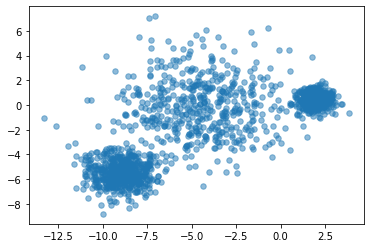

In [15]:
plt.scatter(varied[0][:,0], varied[0][:,1], **parameters)
plt.show()

Jak sobie poradzi DBSCAN?

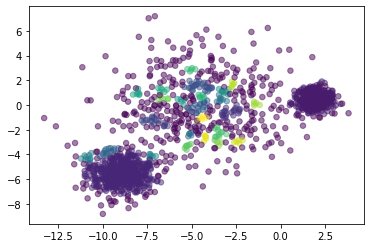

In [16]:
plot_clusters(*_DBSCAN(varied[0]), **parameters)

Jak poradzi sobie KMeans?

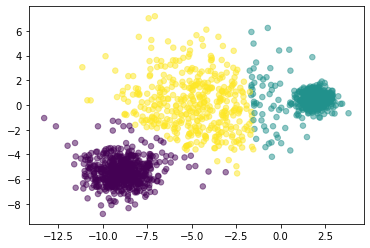

In [17]:
plot_clusters(*_KMeans(varied[0], n_clusters=3), **parameters)

In [18]:
def _GMM(X, n_components, covariance_type='full'):
    gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=covariance_type)
    gmm.fit(X)
    return X, gmm

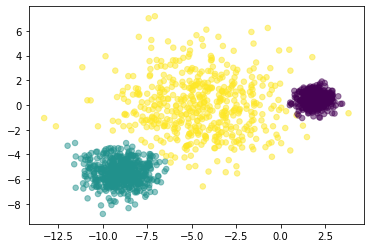

In [19]:
plot_clusters(*_GMM(varied[0], n_components=3), **parameters)

### Zadanie <a name="GMM_task"></a>
Przetestuj metody dla poniższych 3 zbiorów. Zbadaj czasy poszczególnych metod.

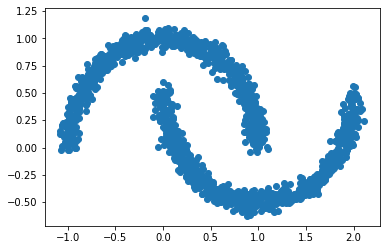

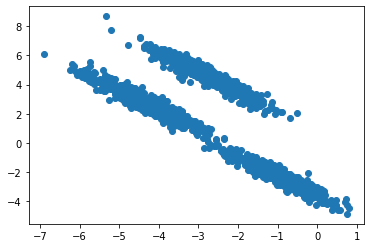

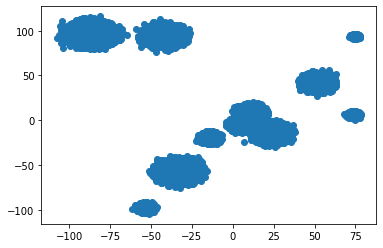

In [20]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1])
plt.show()
plt.scatter(aniso_noisy[0][:,0], aniso_noisy[0][:,1])
plt.show()
plt.scatter(X_batch_blobs[:,0], X_batch_blobs[:,1])
plt.show()

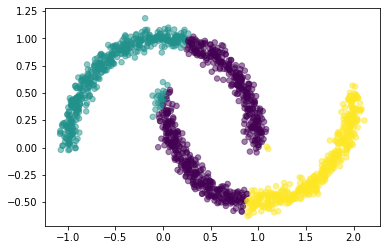

In [35]:
plot_clusters(*_KMeans(noisy_moons, n_clusters=3), **parameters)

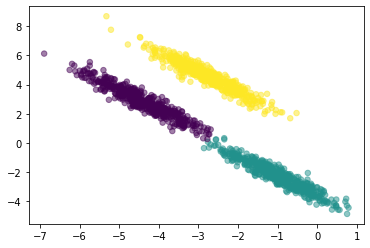

In [36]:
plot_clusters(*_KMeans(aniso_noisy[0], n_clusters=3), **parameters)

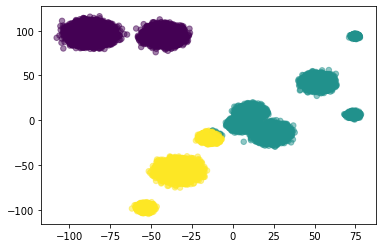

In [39]:
plot_clusters(*_KMeans(X_batch_blobs, n_clusters=3), **parameters)

Więcej: <a name='GMM_sources'></a>
   - https://www.kaggle.com/sid321axn/customer-segments-gmm-vs-k-means-clustering
   - https://github.com/duducheng/clustering_tutorial/blob/master/2_Gaussian_Mixture_and_EM.ipynb

## Standaryzacja <a name="standardization"></a>

In [21]:
x1 = np.concatenate((np.random.normal(150, 5, 400), 
                     np.random.normal(100, 5, 300),
                     np.random.normal(50, 5, 300)),
                    axis=None)
x2 = np.concatenate((np.random.normal(200, 5, 400), 
                     np.random.normal(150, 5, 300),
                     np.random.normal(100, 5, 300)),
                    axis=None)
x3 = np.random.normal(10000, 1000, 1000)

df = pd.DataFrame({'X1': x1,'X2': x2,'X3': x3})
df.head()

,X1,X2,X3
0,150.154796,205.307381,10300.726357
1,140.756582,200.967738,8218.557541
2,153.110094,191.790721,10826.444371
3,143.704458,199.884428,10458.698830
4,155.124995,208.865702,11472.481843


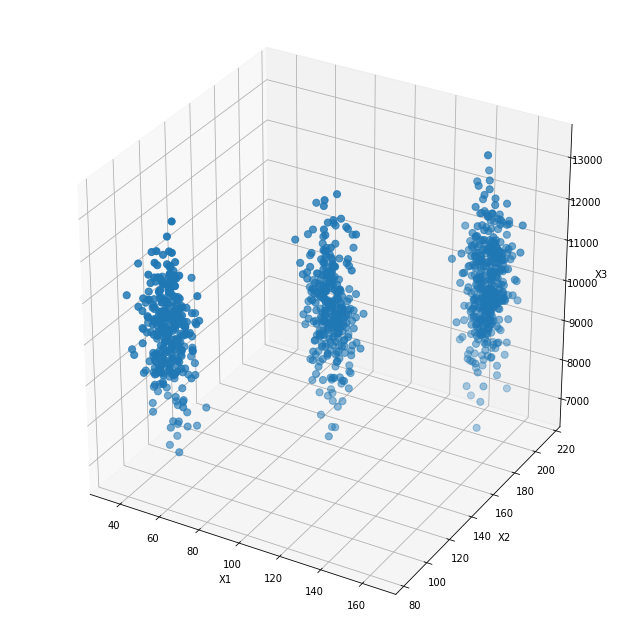

In [22]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.X1, df.X2, df.X3, s=50)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')

plt.tight_layout()
plt.show()


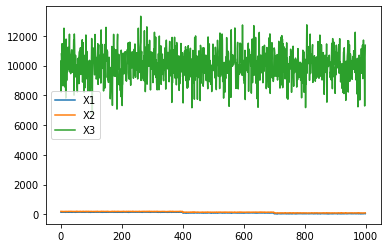

In [23]:
df.plot()

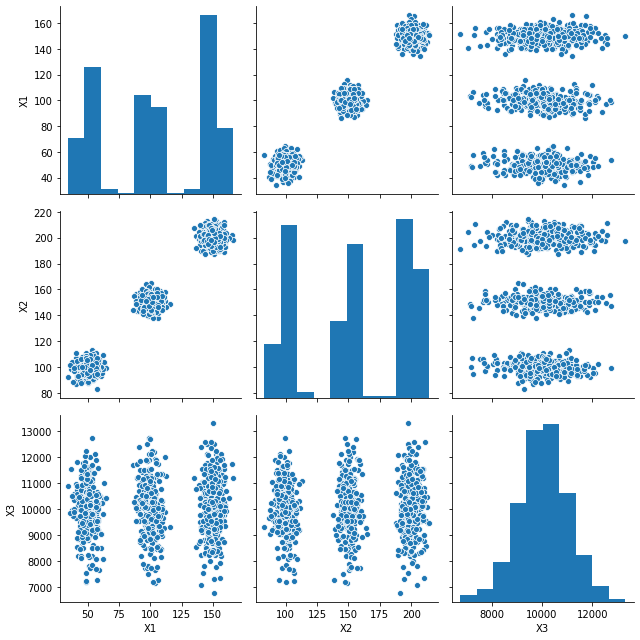

In [24]:
sns.pairplot(df, height=3)
plt.tight_layout()

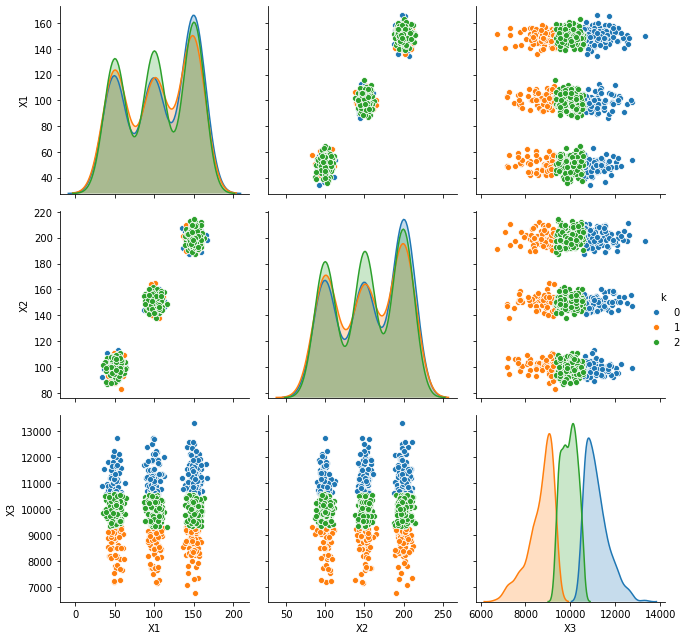

In [25]:
df['k']= hue=_KMeans(df, 3)[1].predict(df)

sns.pairplot(df, height=3, hue='k')
plt.tight_layout()

In [26]:
std_scale = preprocessing.StandardScaler().fit(df.iloc[:,[0,1,2]])
df_std = pd.DataFrame(std_scale.transform(df.iloc[:,[0,1,2]]), columns=["X1", "X2", "X3"])

df_std.head()

,X1,X2,X3
0,1.079313,1.195300,0.247309
1,0.854652,1.091916,-1.817156
2,1.149958,0.873290,0.768557
3,0.925120,1.066108,0.403938
4,1.198124,1.280070,1.409102


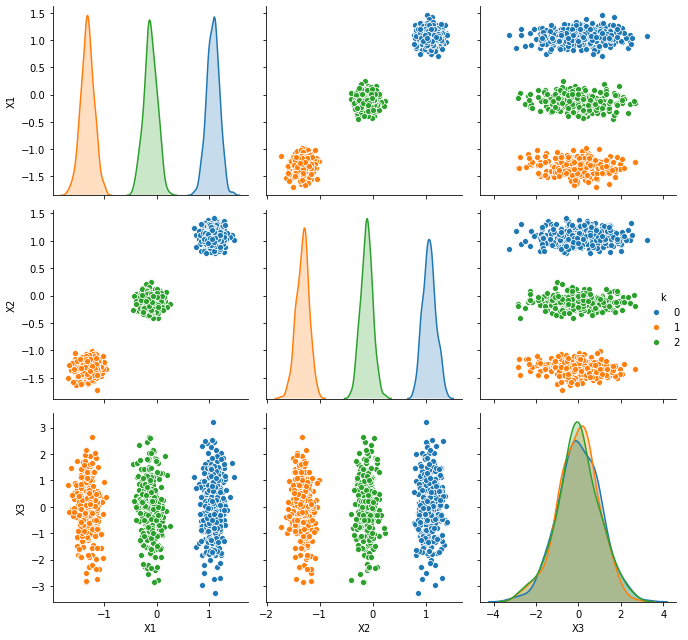

In [27]:
df_std['k']= hue=_KMeans(df_std, 3)[1].predict(df_std)

sns.pairplot(df_std, height=3, hue='k')
plt.tight_layout()

Więcej:
https://sebastianraschka.com/Articles/2014_about_feature_scaling.html